In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import scipy.stats as sps
import scipy.optimize as spo
from datetime import timedelta

In [2]:
tk = yf.Ticker("QQQ")
# Expiration dates
exps = tk.options
# Get options for each expiration
options = pd.DataFrame()
for e in exps:
    opt = tk.option_chain(e)
    opt.calls['optionType'] = 'Call'
    opt.puts['optionType'] = 'Put'
    opt.calls['expirationDate'] = e
    opt.puts['expirationDate'] = e
    
    options = pd.concat([options, pd.concat([opt.calls, opt.puts])])
options = options.reset_index(drop=True)
options['midPrice'] = (options['bid'] + options['ask']) / 2
options['expirationDate'] = pd.to_datetime(options['expirationDate'])

In [3]:
options

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,optionType,expirationDate,midPrice
0,QQQ240412C00300000,2024-04-10 16:52:38+00:00,300.00,137.85,145.51,145.79,0.0,0.0,10.0,11.0,3.371095,True,REGULAR,USD,Call,2024-04-12,145.650
1,QQQ240412C00310000,2024-04-02 14:12:18+00:00,310.00,128.88,135.52,135.79,0.0,0.0,6.0,6.0,3.126955,True,REGULAR,USD,Call,2024-04-12,135.655
2,QQQ240412C00315000,2024-04-10 19:15:07+00:00,315.00,123.31,130.52,130.79,0.0,0.0,11.0,11.0,3.003909,True,REGULAR,USD,Call,2024-04-12,130.655
3,QQQ240412C00320000,2024-04-10 19:10:09+00:00,320.00,117.64,125.52,125.80,0.0,0.0,1.0,1.0,2.890628,True,REGULAR,USD,Call,2024-04-12,125.660
4,QQQ240412C00325000,2024-03-08 14:33:17+00:00,325.00,122.30,115.44,115.89,0.0,0.0,1.0,1.0,0.000010,True,REGULAR,USD,Call,2024-04-12,115.665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6947,QQQ261218P00589780,2024-01-19 18:47:33+00:00,589.78,171.94,157.50,162.36,0.0,0.0,40.0,0.0,0.199860,True,REGULAR,USD,Put,2026-12-18,159.930
6948,QQQ261218P00594780,2024-03-18 20:12:55+00:00,594.78,157.10,146.50,151.48,0.0,0.0,2.0,0.0,0.110986,True,REGULAR,USD,Put,2026-12-18,148.990
6949,QQQ261218P00620000,2024-03-04 19:46:53+00:00,620.00,174.00,175.00,179.91,0.0,0.0,1.0,1.0,0.150887,True,REGULAR,USD,Put,2026-12-18,177.455
6950,QQQ261218P00640000,2024-02-01 17:09:06+00:00,640.00,219.46,192.42,196.62,0.0,0.0,NaN,0.0,0.131082,True,REGULAR,USD,Put,2026-12-18,194.520


In [4]:
pd.to_datetime(opt.underlying['regularMarketTime'] * 1000, unit='ms').normalize()

Timestamp('2024-04-11 00:00:00')

In [5]:
# get trading date
t0 = pd.to_datetime(opt.underlying['regularMarketTime'] * 1000, unit='ms').normalize() - timedelta(0)
options['ttm'] = [(i - t0).days / 365 for i in options['expirationDate']]

# get rid of options that were not traded 
idx = np.where(options.lastTradeDate > t0.tz_localize('UTC'))
options = options.loc[idx].reset_index(drop=True)
options = options[options['optionType'] == 'Call'].reset_index(drop=True)

S_0 = opt.underlying['regularMarketPrice']
rf = 0.03
options["Moneyness"] = round(options["strike"]/S_0,2)

In [6]:
def bs_call(S, strike, ttm, rf, sigma):
    d1 = (np.log(S / strike) + (rf + sigma**2 / 2.0) * ttm) / (sigma * np.sqrt(ttm))
    d2 = d1 - sigma * np.sqrt(ttm)
    return S * sps.norm.cdf(d1) - strike * np.exp(-rf * ttm) * sps.norm.cdf(d2)

def bs_call_iv(c, S, strike, ttm, rf):
    def _inner(sigma):
        d1 = (np.log(S / strike) + (rf + sigma**2 / 2.0) * ttm) / (sigma * np.sqrt(ttm))
        d2 = d1 - sigma * np.sqrt(ttm)
        return c - (S * sps.norm.cdf(d1) - strike * np.exp(-rf * ttm) * sps.norm.cdf(d2))
    return _inner


def bs_put(S, strike, ttm, rf, sigma):
    d1 = (np.log(S / strike) + (rf + sigma**2 / 2.0) * ttm) / (sigma * np.sqrt(ttm))
    d2 = d1 - sigma * np.sqrt(ttm)
    return sps.norm.cdf(-d2) * strike * np.exp(-rf * ttm) - sps.norm.cdf(-d1) * S

def bs_put_iv(p, S, strike, ttm, rf):
    def _inner(sigma):
        d1 = (np.log(S / strike) + (rf + sigma**2 / 2.0) * ttm) / (sigma * np.sqrt(ttm))
        d2 = d1 - sigma * np.sqrt(ttm)
        return p - (sps.norm.cdf(-d2) * strike * np.exp(-rf * ttm) - sps.norm.cdf(-d1) * S)
    return _inner

In [7]:
ivs = []
for i in options.index:
    if options.loc[i, 'optionType'] == 'Call':
        c = options.loc[i, 'midPrice']
        strike = options.loc[i, 'strike']
        ttm = options.loc[i, 'ttm']
        try:
            ivs.append(spo.bisect(bs_call_iv(c ,S_0, strike, ttm, rf), 0.001, 1))
        except:
            ivs.append(np.nan)
    else:
        p = options.loc[i, 'midPrice']
        strike = options.loc[i, 'strike']
        ttm = options.loc[i, 'ttm']
        try:
            ivs.append(spo.bisect(bs_put_iv(p ,S_0, strike, ttm, rf), 0.001, 1))
        except:
            ivs.append(np.nan)
    
options['impliedVolatility'] = ivs
options = options.dropna().reset_index(drop=True)

In [8]:
options

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,optionType,expirationDate,midPrice,ttm,Moneyness
0,QQQ240412C00405000,2024-04-11 17:23:33+00:00,405.00,38.54,40.57,40.84,5.160000,15.458358,54.0,118.0,0.998647,True,REGULAR,USD,Call,2024-04-12,40.705,0.002740,0.91
1,QQQ240412C00406000,2024-04-11 17:03:51+00:00,406.00,35.68,39.57,39.84,-0.060001,-0.167883,67.0,46.0,0.977067,True,REGULAR,USD,Call,2024-04-12,39.705,0.002740,0.91
2,QQQ240412C00409000,2024-04-11 16:43:11+00:00,409.00,32.45,36.57,36.96,0.760000,2.398234,8.0,2.0,0.943696,True,REGULAR,USD,Call,2024-04-12,36.765,0.002740,0.92
3,QQQ240412C00410000,2024-04-11 19:45:41+00:00,410.00,36.35,35.57,35.85,8.679998,31.369707,78.0,147.0,0.893316,True,REGULAR,USD,Call,2024-04-12,35.710,0.002740,0.92
4,QQQ240412C00411000,2024-04-11 16:01:22+00:00,411.00,30.70,34.57,34.96,3.800001,14.126399,7.0,21.0,0.899329,True,REGULAR,USD,Call,2024-04-12,34.765,0.002740,0.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102,QQQ261218C00510000,2024-04-11 18:01:40+00:00,510.00,53.50,54.00,58.81,0.820000,1.556567,1.0,17.0,0.229216,False,REGULAR,USD,Call,2026-12-18,56.405,2.687671,1.15
1103,QQQ261218C00540000,2024-04-11 19:51:42+00:00,540.00,44.88,42.00,47.00,2.470001,5.824101,6.0,16.0,0.220665,False,REGULAR,USD,Call,2026-12-18,44.500,2.687671,1.21
1104,QQQ261218C00544780,2024-04-11 19:51:42+00:00,544.78,42.58,40.50,45.21,3.220001,8.180898,6.0,21.0,0.219661,False,REGULAR,USD,Call,2026-12-18,42.855,2.687671,1.22
1105,QQQ261218C00630000,2024-04-11 14:43:31+00:00,630.00,18.53,17.50,22.50,3.520001,23.451036,1.0,6.0,0.202185,False,REGULAR,USD,Call,2026-12-18,20.000,2.687671,1.41


$$
\begin{align*}
\sigma(t,y) &:= \sqrt{\frac{2\frac{\partial C^M}{\partial t}(t,y)+2ry\frac{\partial C^M}{\partial y}(t,y)}{y^2\frac{\partial^2 C^M}{\partial y^2}(t,y)}}
\\
, where \quad \frac{\partial C^M}{\partial t}(t,y) &=-rK\frac{\partial C^M}{\partial K}(t,x,K)+\frac{\sigma^2x^2}{2}\frac{K^2}{x^2}\frac{\partial^2 C^M}{\partial K^2}(t,x,K)
\\
\frac{\partial C^M}{\partial K}(t,y)&=\frac{1}{K}C(t,x,K)-\frac{x}{K}\frac{\partial C^M}{\partial x}(t,x,K)
\\
\frac{\partial^2 C^M}{\partial K^2}(t,y)&=\frac{x^2}{K^2}\frac{\partial^2 C^M}{\partial K^2}(t,x,K)

\end{align*} 
$$

In [9]:
def dcdk_func(c, S, strike, ttm, rf, sigma):
    d1 = (np.log(S / strike) + (rf + sigma**2 / 2.0) * ttm) / (sigma * np.sqrt(ttm))
    delta = sps.norm.cdf(d1)
    return S / strike * (1 / S * c - delta)

def d2cdk2_func(S, strike, ttm, rf, sigma):
    d1 = (np.log(S / strike) + (rf + sigma**2 / 2.0) * ttm) / (sigma * np.sqrt(ttm))
    nprimed1 = sps.norm.pdf(d1)
    gamma =  nprimed1 / (S * sigma * np.sqrt(ttm))
    return (S ** 2 / strike ** 2) * gamma

def dcdt_func(c, S, strike, ttm, rf, sigma):
    dcdk = dcdk_func(c, S, strike, ttm, rf, sigma)
    d2cdk2 = d2cdk2_func(S, strike, ttm, rf, sigma)
    return - rf * strike * dcdk + (sigma ** 2 * S ** 2) / 2 * (strike ** 2 / S ** 2) * d2cdk2

In [10]:
lvs = []
for i in options.index:
    c = options.loc[i, 'midPrice']
    strike = options.loc[i, 'strike']
    ttm = (options.loc[i, 'expirationDate'] - t0).days / 365
    sigma = options.loc[i, 'impliedVolatility']

    dcdt = dcdt_func(c, S_0, strike, ttm, rf, sigma)
    dcdk = dcdk_func(c, S_0, strike, ttm, rf, sigma)
    d2cdk2 = d2cdk2_func(S_0, strike, ttm, rf, sigma)

    lv = np.sqrt((2 * dcdt + 2 * rf * strike * dcdk) / (strike ** 2 * d2cdk2))
    lvs.append(lv)
    
options['localVolatility'] = lvs

In [11]:
options

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,optionType,expirationDate,midPrice,ttm,Moneyness,localVolatility
0,QQQ240412C00405000,2024-04-11 17:23:33+00:00,405.00,38.54,40.57,40.84,5.160000,15.458358,54.0,118.0,0.998647,True,REGULAR,USD,Call,2024-04-12,40.705,0.002740,0.91,0.998647
1,QQQ240412C00406000,2024-04-11 17:03:51+00:00,406.00,35.68,39.57,39.84,-0.060001,-0.167883,67.0,46.0,0.977067,True,REGULAR,USD,Call,2024-04-12,39.705,0.002740,0.91,0.977067
2,QQQ240412C00409000,2024-04-11 16:43:11+00:00,409.00,32.45,36.57,36.96,0.760000,2.398234,8.0,2.0,0.943696,True,REGULAR,USD,Call,2024-04-12,36.765,0.002740,0.92,0.943696
3,QQQ240412C00410000,2024-04-11 19:45:41+00:00,410.00,36.35,35.57,35.85,8.679998,31.369707,78.0,147.0,0.893316,True,REGULAR,USD,Call,2024-04-12,35.710,0.002740,0.92,0.893316
4,QQQ240412C00411000,2024-04-11 16:01:22+00:00,411.00,30.70,34.57,34.96,3.800001,14.126399,7.0,21.0,0.899329,True,REGULAR,USD,Call,2024-04-12,34.765,0.002740,0.92,0.899329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102,QQQ261218C00510000,2024-04-11 18:01:40+00:00,510.00,53.50,54.00,58.81,0.820000,1.556567,1.0,17.0,0.229216,False,REGULAR,USD,Call,2026-12-18,56.405,2.687671,1.15,0.229216
1103,QQQ261218C00540000,2024-04-11 19:51:42+00:00,540.00,44.88,42.00,47.00,2.470001,5.824101,6.0,16.0,0.220665,False,REGULAR,USD,Call,2026-12-18,44.500,2.687671,1.21,0.220665
1104,QQQ261218C00544780,2024-04-11 19:51:42+00:00,544.78,42.58,40.50,45.21,3.220001,8.180898,6.0,21.0,0.219661,False,REGULAR,USD,Call,2026-12-18,42.855,2.687671,1.22,0.219661
1105,QQQ261218C00630000,2024-04-11 14:43:31+00:00,630.00,18.53,17.50,22.50,3.520001,23.451036,1.0,6.0,0.202185,False,REGULAR,USD,Call,2026-12-18,20.000,2.687671,1.41,0.202185


In [12]:
options['impliedVolatility'] / options['localVolatility']

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
1102    1.0
1103    1.0
1104    1.0
1105    1.0
1106    1.0
Length: 1107, dtype: float64

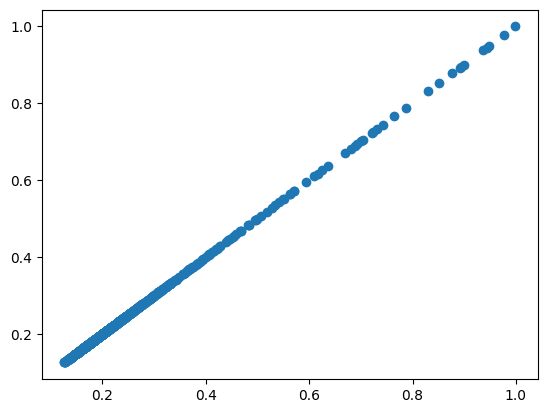

In [13]:
plt.scatter(options['impliedVolatility'], options['localVolatility'])

In [14]:
lv_surface = pd.DataFrame()
for t in exps:
    ivc = options[(options["expirationDate"] == t)].sort_values("strike").set_index('Moneyness')["localVolatility"]
    adj_ivc = ivc.groupby("Moneyness").mean()
    adj_ivc.name = t
    lv_surface = pd.concat([lv_surface, adj_ivc], axis = 1)
lv_surface.columns = pd.to_datetime(lv_surface.columns)
lv_surface = lv_surface.sort_index()
lv_surface = lv_surface.interpolate(limit_area="inside")
lv_surface = lv_surface.loc[(lv_surface.index > 0.9) & (lv_surface.index < 1.1)]
lv_surface = lv_surface.iloc[:,:25]

Text(0.5, 0.92, 'LV Surface of QQQ')

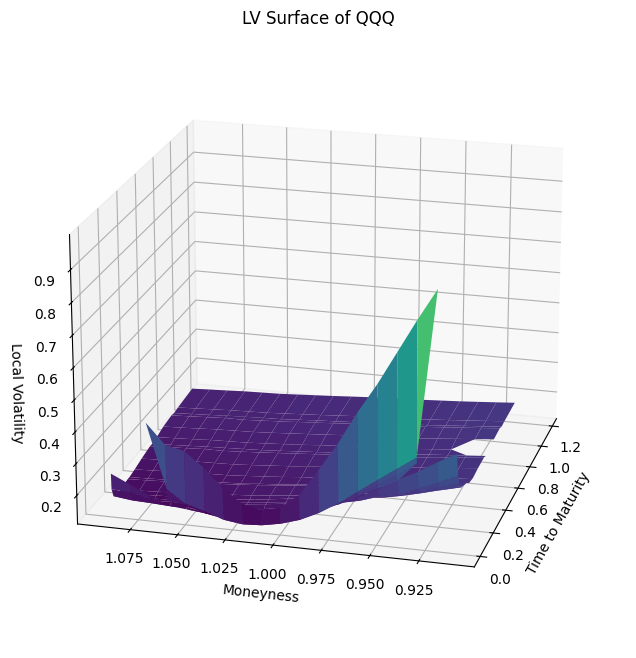

In [15]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
#Singapore time is ahead 1 day to the US time
time2maturity = [((i - datetime.today()).days + 1) / 365 for i in lv_surface.columns]

%matplotlib inline
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')


X, Y = np.meshgrid(time2maturity, lv_surface.index)
ax.plot_surface(X, Y, lv_surface, linewidth=0.2, cmap='viridis')
ax.view_init(20, -165) 
ax.set_xlabel("Time to Maturity")
ax.set_ylabel("Moneyness")
ax.set_zlabel("Local Volatility")
ax.set_title('LV Surface of QQQ')